In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd

In [3]:
folder_path=r"/kaggle/input/final-data1-55/final-data1-55/"
metadata_path=r"/kaggle/input/csv1-555/csv1-55.csv"

In [4]:
metadata=pd.read_csv(metadata_path)

In [6]:
metadata

,id,file_name,transcription
0,1,ad1_chunk105.mp3,face and this is the destination MAC address....
1,2,ad1_chunk53.mp3,"is the IP address, this is the MAC address. F..."
2,3,ad1_chunk12.mp3,with the port number B and this process is as...
3,4,ad1_chunk43.mp3,the network layer part of our series. For tim...
4,5,ad1_chunk51.mp3,"interface, this router has two interfaces, on..."
...,...,...,...
4817,1500,ad46ck89.mp3,shorter coverage area than satellite communic...
4818,1501,ad52ck36.mp3,happening perfectly. So far we have seen appl...
4819,1502,ad52ck107.mp3,The destination MAC address so that this inte...
4820,1503,ad48ck65.mp3,activities of Mac sublayer. I hope you guys e...


In [7]:
metadata.isnull().sum()

id                 0
file_name        101
transcription     70
dtype: int64

In [8]:
metadata=metadata.dropna()

In [9]:
metadata.isnull().sum()

id               0
file_name        0
transcription    0
dtype: int64

In [10]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras.models import load_model
import tensorflow as tf
import librosa

2024-06-21 12:25:46.087172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 12:25:46.087273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 12:25:46.215051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:

split=int(len(metadata)*0.90)

In [12]:
#train test split
df_train=metadata[:split]
df_test=metadata[split:]

In [13]:

frame_length=384
frame_step=160
fft_length=384

In [14]:
def load_audio(file_path,mono=True):
    # Load the audio file in stereo
    file_path = file_path.numpy().decode('utf-8') 
    audio = librosa.load(file_path, mono=mono)
    return audio

In [15]:
import os
import librosa


def encode_single_sample(filepath,label):
       # Ensure filepath is a string
    file_path = tf.strings.join([folder_path, filepath])
    
    # Use tf.py_function to load the audio file
    audio = tf.py_function(load_audio, [file_path], tf.float32)
    
    # Ensure the shape is set correctly (librosa.load returns 1D array)
    audio.set_shape([None])
    audio=tf.cast(audio,tf.float32)
    spectogram=tf.signal.stft(audio,frame_length=frame_length,frame_step=frame_step,fft_length=fft_length)
    spectogram=tf.abs(spectogram)
    spectogram=tf.math.pow(spectogram,0.5)
    means=tf.math.reduce_mean(spectogram,1,keepdims=True)
    stddevs=tf.math.reduce_std(spectogram,1,keepdims=True)
    spectogram=(spectogram-means)/(stddevs+1e-10)
    label=tf.strings.lower(label)
    label=tf.strings.unicode_split(label,input_encoding="UTF-8")
    label=char_to_num(label)
    return spectogram,label

In [16]:
import tensorflow as tf
from tensorflow import keras

characters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ']

In [17]:
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

In [18]:
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True, oov_token="")

In [19]:
batch_size=32
train_dataset=tf.data.Dataset.from_tensor_slices((list(df_train['file_name']),list(df_train['transcription'])))

In [20]:
train_dataset=(train_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

In [21]:
test_dataset=tf.data.Dataset.from_tensor_slices((list(df_test['file_name']),list(df_test['transcription'])))
test_dataset=(test_dataset.map(encode_single_sample,num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

In [22]:
def CTCLoss(y_true,y_pred):
    batch_len=tf.cast(tf.shape(y_true)[0],dtype='int64')
    input_length=tf.cast(tf.shape(y_pred)[1],dtype='int64')
    label_length=tf.cast(tf.shape(y_true)[1],dtype='int64')
    input_length=input_length*tf.ones(shape=(batch_len,1),dtype='int64')
    label_length=label_length*tf.ones(shape=(batch_len,1),dtype='int64')
    loss=keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
    return loss

In [23]:
def build_model(input_dim,output_dim,rnn_layers=5,rnn_units=128):
    input_spectrogram=layers.Input((None,input_dim),name="input")
    x=layers.Reshape((-1,input_dim,1),name="expand_dim")(input_spectrogram)#2d cnn
    x=layers.Conv2D(filters=32,kernel_size=[11,41],strides=[2,2],padding="same",use_bias=False,name="conv1")(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU(name="conv_1_relu")(x)
    
    x=layers.Conv2D(filters=32,kernel_size=[11,21],strides=[1,2],padding="same",use_bias=False,name="conv2")(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU(name="conv_2_relu")(x)
    x=layers.Reshape((-1, x.shape[-2]* x.shape[-1]))(x)
    
    for i in range(1,rnn_layers+1):
        recurrent=layers.GRU(units=rnn_units,activation="tanh",recurrent_activation="sigmoid",
                            use_bias=True,return_sequences=True,reset_after=True)
        x=layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
        
    x=layers.Dense(units=rnn_units+2,name="Dense")(x)
    x=layers.ReLU(name="dense_2_relu")(x)
    x=layers.Dropout(rate=0.5)(x)
    output=layers.Dense(units=output_dim+1, activation="softmax")(x)
    model=keras.Model(input_spectrogram, output)
    opt=keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    
    return model

In [24]:
model=build_model(input_dim=193,output_dim=char_to_num.vocabulary_size(),rnn_units=512)

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 193)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dim (Reshape)            │ (None, None, 193, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, 97, 32)   │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 97, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_relu (ReLU)              │ (None, None, 97, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, None, 49, 32)   │       236,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 49, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_relu (ReLU)              │ (None, None, 49, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 1568)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 1024)     │     6,395,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, None, 514)      │       526,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2_relu (ReLU)             │ (None, None, 514)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 514)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 29)       │        14,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,087,865 (99.52 MB)

 Trainable params: 26,087,737 (99.52 MB)

 Non-trainable params: 128 (512.00 B)

In [32]:
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [33]:
def decode_batch_predictions(pred):
    print(pred.shape[0])
    print(pred.shape[1])
    input_len=np.ones(pred.shape[0])*pred.shape[1]
    
    results=keras.backend.ctc_decode(pred,input_length=input_len, greedy=True)[0][0]
    
    output_text=[]
    for result in results:
        result=tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [34]:
validation_callback = CallbackEval(test_dataset)

In [35]:
class SaveEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, save_freq, **kwargs):
        super(SaveEveryNEpochs, self).__init__(**kwargs)
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            save_path = f"/kaggle/working/edu-data_{25+epoch+1}.h5"
            self.model.save(save_path)
            print(f"Model saved to {save_path}")

In [36]:
save_callback = SaveEveryNEpochs(save_freq=5)

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

model=load_model("/kaggle/input/40-epochs/model_epoch_40.h5",compile=False)

opt=keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss=CTCLoss)

history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[save_callback])


model.save("edu-data-50-epochs.h5")

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - loss: 324.1860 - val_loss: 281.4043
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - loss: 249.6068 - val_loss: 231.5229
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - loss: 204.7480 - val_loss: 223.9110
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - loss: 182.5073 - val_loss: 212.6683
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 171.0556Model saved to /kaggle/working/edu-data_30.h5
131/131 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - loss: 171.0861 - val_loss: 208.8248
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - loss: 159.8154 - val_loss: 203.3877
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - loss: 156.0195 - val_loss: 203.8151
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - loss: 150.9377 - val_loss: 205.7876
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - loss: 143.1130 - val_loss: 206.4321
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 136.5162Model saved

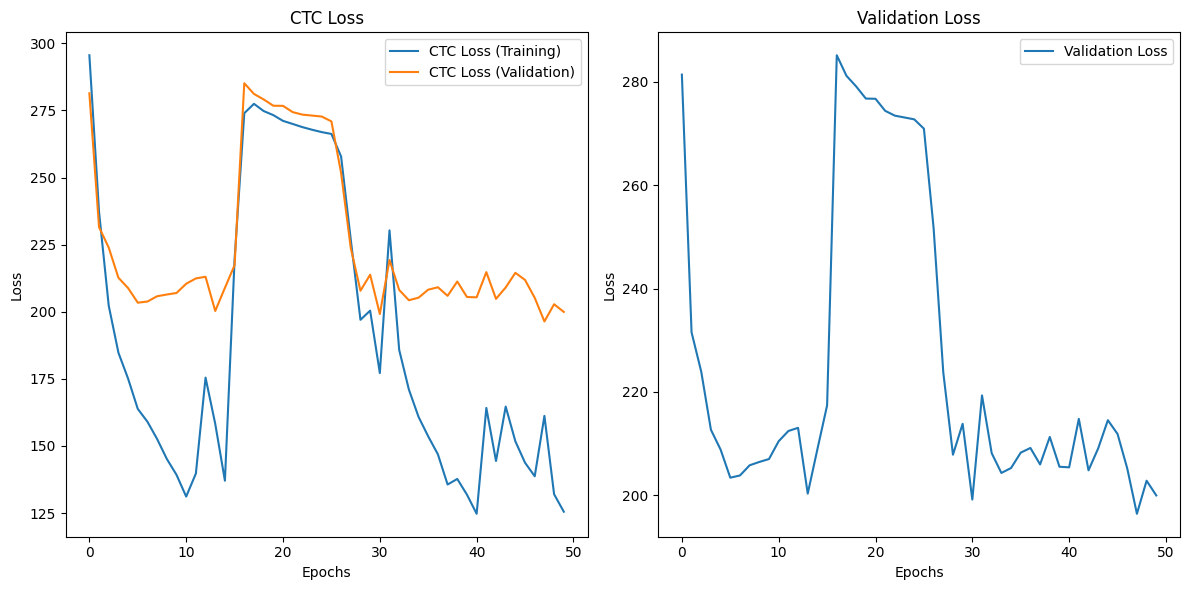

In [45]:
import matplotlib.pyplot as plt

# Extract the history from the model.fit call
history = history.history

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Plot CTC loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='CTC Loss (Training)')
plt.plot(history['val_loss'], label='CTC Loss (Validation)')
plt.title('CTC Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss separately if needed
plt.subplot(1, 2, 2)
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [42]:
def decode_references(y):
   
    output_text=[]
    for label in y:
        label=tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        output_text.append(label)
    return output_text

In [46]:
#Important
predictions = []
targets = []
count = 0

for batch in test_dataset:
    X, y = batch
    print(X.shape)
    
    batch_predictions = model.predict(X)
    count += 32
    print(f"batch no {count}")
    
    batch_predictions = decode_batch_predictions(batch_predictions)
    batch_references = decode_references(y)
    
    # Ensure all predictions and references are strings and filter out empty strings
    filtered_predictions = []
    filtered_references = []
    
    for pred, ref in zip(batch_predictions, batch_references):
        pred_str = str(pred).strip()
        ref_str = str(ref).strip()
        if pred_str and ref_str:  # Ensure both prediction and reference are not empty
            filtered_predictions.append(pred_str)
            filtered_references.append(ref_str)
    
    #print(filtered_references)
    #print(filtered_predictions)
    
    if filtered_references and filtered_predictions:
        print(wer(filtered_references, filtered_predictions))
    
    predictions.extend(filtered_predictions)
    targets.extend(filtered_references)
    
    #print(wer(targets, predictions))

# At the end, you can calculate WER for the entire dataset if needed
if targets and predictions:
    print(wer(targets, predictions))
for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

(32, 785, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
batch no 32
32
393
0.6484962406015038
(32, 796, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
batch no 64
32
398
0.6830708661417323
(32, 803, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
batch no 96
32
402
0.6392857142857142
(32, 781, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
batch no 128
32
391
0.6600719424460432
(32, 785, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
batch no 160
32
393
0.6025408348457351
(32, 788, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
batch no 192
32
394
0.667910447761194
(32, 803, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
batch no 224
32
402
0.6334586466165414
(32, 781, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
batch no 256
32
391
0.6693227091633466
(32, 796, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
batch no 288
32
398
0.6458715596330276
(32, 792, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
batch no 320
32
396
0.6666666666666666
(32, 781, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
batch no 352
32
391


In [38]:
!pip install jiwer

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.5 MB/s eta 0:00:00a 0:00:01


In [39]:
from jiwer import wer

In [ ]:
python --version

In [48]:
!pip install moviepy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 6.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 58.6 MB/s eta 0:00:00:00:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=3487e4b8ebdeaa3e9c7669b83a72f6567a1aafcecb53d451133fc0140678a0d4
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [49]:
from moviepy.editor import VideoFileClip
def extract_audio(video_path):
    output_path="ad_from_vid.mp3"
    video = VideoFileClip(video_path)
    audio = video.audio
    
    # Write audio to file
    audio.write_audiofile(output_path, codec='mp3')
    return output_path

In [50]:
def encode_pred_sample(filepath):
    audio=load_audio_pred(filepath)
    audio=tf.cast(audio,tf.float32)
    spectogram=tf.signal.stft(audio,frame_length=frame_length,frame_step=frame_step,fft_length=fft_length)
    spectogram=tf.abs(spectogram)
    spectogram=tf.math.pow(spectogram,0.5)
    means=tf.math.reduce_mean(spectogram,1,keepdims=True)
    stddevs=tf.math.reduce_std(spectogram,1,keepdims=True)
    spectogram=(spectogram-means)/(stddevs+1e-10)
   
    return spectogram

In [51]:

def load_audio_pred(file_path,mono=True):
    # Load the audio file in stereo
    file_path = file_path
    audio, sample_rate = librosa.load(file_path, mono=mono)
    return audio

In [52]:
def predict(filepath,model):
    output_path=extract_audio(filepath)
    print(output_path)
    spectogram=encode_pred_sample(output_path)
    print(spectogram.shape)
    r_spectogram = tf.expand_dims(spectogram, axis=0)
 
    
    pred=model.predict(r_spectogram)
    output=decode_batch_predictions(pred)
    print(output)
    return output

In [53]:
output=predict("/kaggle/input/1mintest/neso-1min.mp4",model)

MoviePy - Writing audio in ad_from_vid.mp3


MoviePy - Done.
ad_from_vid.mp3
(8271, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1
4136
[' hellove recones wecome to the next lectur in the computer network series and oy we will se addressing in networking this lecture is coated inode to eal u to understand thins ina betev wy and ina practical wa so we will se thoucomes of to daysission now apon te completion of the session the lerner will be able to understand the role of port addressing ip addressing and mac addressing in compute network bith examples we have alrady seen port addressing ip addressing and mac addressing now we will understan how these addresses tel inoder to take a packet from the source computer souce process to the destination computers estination proces we have alady seen this example in the previous lecture suppos if this is the sinter computer and this is the receiver computer let is assue that dea is the ip address of this ande computer and pe is the ip addres of the receiver computer ar nin the sender computer 

In [54]:
output=predict("/kaggle/input/testing-long/Components of a Computer Network.mp4",model)

MoviePy - Writing audio in ad_from_vid.mp3


MoviePy - Done.
ad_from_vid.mp3
(81986, 193)
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1
40993
[' heloveryvone welcome back to the computer networkscourse and today we will se te vatis compoents of o computer network aton the completion of the session we will be able to understand nodes we will also understand whater the different mediain computer network and what ar the vaiou services ofer by computer network an computer network has e compoentes nodes media and services firstly we will d wihtnodes we have alredy se nodes inteta in the previous lectures and no can send or recei or both sendan recive the data and these nodes can be i nnod or an intemediayknode e can call in nodes as nd devices and intervmeryy nodes as intermedary devices we will for s ee nodes enos are te nodes that is going to be the starting poingt i the communication o the enpointithe communication if two devices whants to communicate with each other  the device which incetes this communication is an an deviice and the d

In [42]:
!pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 2.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 33.1 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=09c26805ef393943d625e7a09e78d52b2d261b6f737c2d73e11088624cad3563
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
